# 📈 Time Series Forecasting: Store Sales using SARIMA

This notebook demonstrates time series forecasting using SARIMA on store sales data with comparison to ARIMA and Prophet models.

## Project Structure
1. Data Loading and Preprocessing
2. Exploratory Data Analysis (EDA)
3. Model Development
   - SARIMA Implementation
   - ARIMA Baseline
   - Prophet Comparison
4. Model Evaluation
5. Results Visualization

## 1. Data Loading and Preprocessing

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [4]:
def load_data():
    """Load and preprocess the store sales data"""
    try:
        # Load datasets
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')
        stores_df = pd.read_csv('stores.csv')
        features_df = pd.read_csv('features.csv')
        
        # Convert date columns to datetime
        for df in [train_df, test_df, features_df]:
            df['Date'] = pd.to_datetime(df['Date'])
        
        # Merge datasets
        train_data = train_df.merge(stores_df, on='Store', how='left')
        train_data = train_data.merge(features_df, on=['Store', 'Date'], how='left')
        
        # Sort by date and handle missing values
        train_data = train_data.sort_values('Date').ffill()
        
        return train_data
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

def prepare_time_series(data, store_id=1, dept_id=1):
    """Prepare time series data for a specific store and department"""
    try:
        # Filter data for specific store and department
        store_data = data[(data['Store'] == store_id) & (data['Dept'] == dept_id)]
        
        # Set date as index
        store_data = store_data.set_index('Date')
        
        # Create weekly sales time series
        weekly_sales = store_data['Weekly_Sales'].resample('W').sum()
        
        return weekly_sales
    except Exception as e:
        print(f"Error preparing time series: {str(e)}")
        return None

## 2. Exploratory Data Analysis

In [5]:
def plot_time_series(weekly_sales):
    """Plot the time series data with interactive visualization"""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=weekly_sales.index, y=weekly_sales.values,
                           mode='lines', name='Weekly Sales'))
    fig.update_layout(title='Weekly Sales Time Series',
                     xaxis_title='Date',
                     yaxis_title='Sales')
    fig.show()

def detect_seasonality(weekly_sales):
    """Detect seasonality in the time series"""
    # Plot ACF and PACF
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(weekly_sales, ax=ax1, lags=52)
    plot_pacf(weekly_sales, ax=ax2, lags=52)
    plt.tight_layout()
    plt.show()
    
    # Seasonal decomposition
    result = seasonal_decompose(weekly_sales, model='additive', period=52)
    fig = result.plot()
    fig.set_size_inches(12, 8)
    plt.show()
    
    return 52  # Weekly seasonality

## 3. Model Development

### 3.1 SARIMA Implementation

In [6]:
def grid_search_sarima(weekly_sales, seasonal_period=52):
    """Perform grid search with constrained parameter ranges"""
    # Constrained parameter ranges
    p = d = q = range(0, 2)
    P = D = Q = range(0, 2)
    
    best_aic = float('inf')
    best_params = best_seasonal_params = None
    
    for p1 in p:
        for d1 in d:
            for q1 in q:
                for P1 in P:
                    for D1 in D:
                        for Q1 in Q:
                            try:
                                model = SARIMAX(weekly_sales, 
                                              order=(p1,d1,q1), 
                                              seasonal_order=(P1,D1,Q1,seasonal_period),
                                              enforce_stationarity=False)
                                results = model.fit(disp=False)
                                
                                if results.aic < best_aic:
                                    best_aic = results.aic
                                    best_params = (p1,d1,q1)
                                    best_seasonal_params = (P1,D1,Q1,seasonal_period)
                                    
                            except:
                                continue
    
    return best_params, best_seasonal_params

def train_sarima(weekly_sales, p, d, q, P, D, Q, s):
    """Train SARIMA model with cross-validation"""
    # Split data
    train_size = int(len(weekly_sales) * 0.8)
    train, test = weekly_sales[:train_size], weekly_sales[train_size:]
    
    # Validate parameters
    min_data_needed = max(p, q, P*s, Q*s) + d + D*s + 1
    if len(train) < min_data_needed:
        raise ValueError(f"Insufficient data. Need {min_data_needed} points, have {len(train)}")
    
    # Train model
    model = SARIMAX(train, 
                   order=(p,d,q), 
                   seasonal_order=(P,D,Q,s),
                   enforce_stationarity=False)
    
    model_fit = model.fit(disp=False)
    
    # Evaluate
    predictions = model_fit.forecast(steps=len(test))
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    
    return model_fit, train, test, mae, rmse

### 3.2 ARIMA Baseline

In [7]:
def train_arima(weekly_sales, p=2, d=1, q=2):
    """Train ARIMA model as baseline"""
    train_size = int(len(weekly_sales) * 0.8)
    train, test = weekly_sales[:train_size], weekly_sales[train_size:]
    
    model = ARIMA(train, order=(p,d,q))
    model_fit = model.fit()
    
    predictions = model_fit.forecast(steps=len(test))
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    
    return model_fit, train, test, mae, rmse

### 3.3 Prophet Model

In [8]:
def train_prophet(weekly_sales):
    """Train Prophet model for comparison"""
    # Prepare data
    df = weekly_sales.reset_index()
    df.columns = ['ds', 'y']
    
    train_size = int(len(df) * 0.8)
    train, test = df.iloc[:train_size], df.iloc[train_size:]
    
    # Fit model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    model.fit(train)
    
    # Make predictions
    future = model.make_future_dataframe(periods=len(test), freq='W')
    forecast = model.predict(future)
    
    # Evaluate
    preds = forecast.iloc[-len(test):]['yhat'].values
    mae = mean_absolute_error(test['y'], preds)
    rmse = np.sqrt(mean_squared_error(test['y'], preds))
    
    return model, train, test, mae, rmse

## 4. Model Evaluation and Visualization

In [9]:
def evaluate_models(weekly_sales):
    """Evaluate all models and compare performance"""
    # SARIMA
    sarima_params, seasonal_params = grid_search_sarima(weekly_sales)
    sarima_model, sarima_train, sarima_test, sarima_mae, sarima_rmse = train_sarima(
        weekly_sales, *sarima_params, *seasonal_params)
    
    # ARIMA
    arima_model, arima_train, arima_test, arima_mae, arima_rmse = train_arima(weekly_sales)
    
    # Prophet
    prophet_model, prophet_train, prophet_test, prophet_mae, prophet_rmse = train_prophet(weekly_sales)
    
    # Create comparison table
    results = pd.DataFrame({
        'Model': ['SARIMA', 'ARIMA', 'Prophet'],
        'MAE': [sarima_mae, arima_mae, prophet_mae],
        'RMSE': [sarima_rmse, arima_rmse, prophet_rmse]
    })
    
    print("\nModel Comparison:")
    print(results.to_markdown(index=False))
    
    # Plot results
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sarima_test.index, y=sarima_test.values, name='Actual', mode='lines'))
    
    # Add SARIMA predictions
    sarima_preds = sarima_model.forecast(steps=len(sarima_test))
    fig.add_trace(go.Scatter(x=sarima_test.index, y=sarima_preds, name='SARIMA', mode='lines'))
    
    # Add ARIMA predictions
    arima_preds = arima_model.forecast(steps=len(arima_test))
    fig.add_trace(go.Scatter(x=arima_test.index, y=arima_preds, name='ARIMA', mode='lines'))
    
    # Add Prophet predictions (need to align dates)
    future = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='W')
    prophet_forecast = prophet_model.predict(future)
    prophet_preds = prophet_forecast.iloc[-len(prophet_test):]['yhat']
    fig.add_trace(go.Scatter(x=prophet_test['ds'], y=prophet_preds, name='Prophet', mode='lines'))
    
    fig.update_layout(title='Model Predictions Comparison',
                     xaxis_title='Date',
                     yaxis_title='Sales')
    fig.show()
    
    return {
        'sarima': (sarima_model, sarima_mae, sarima_rmse),
        'arima': (arima_model, arima_mae, arima_rmse),
        'prophet': (prophet_model, prophet_mae, prophet_rmse)
    }

## 5. Main Execution

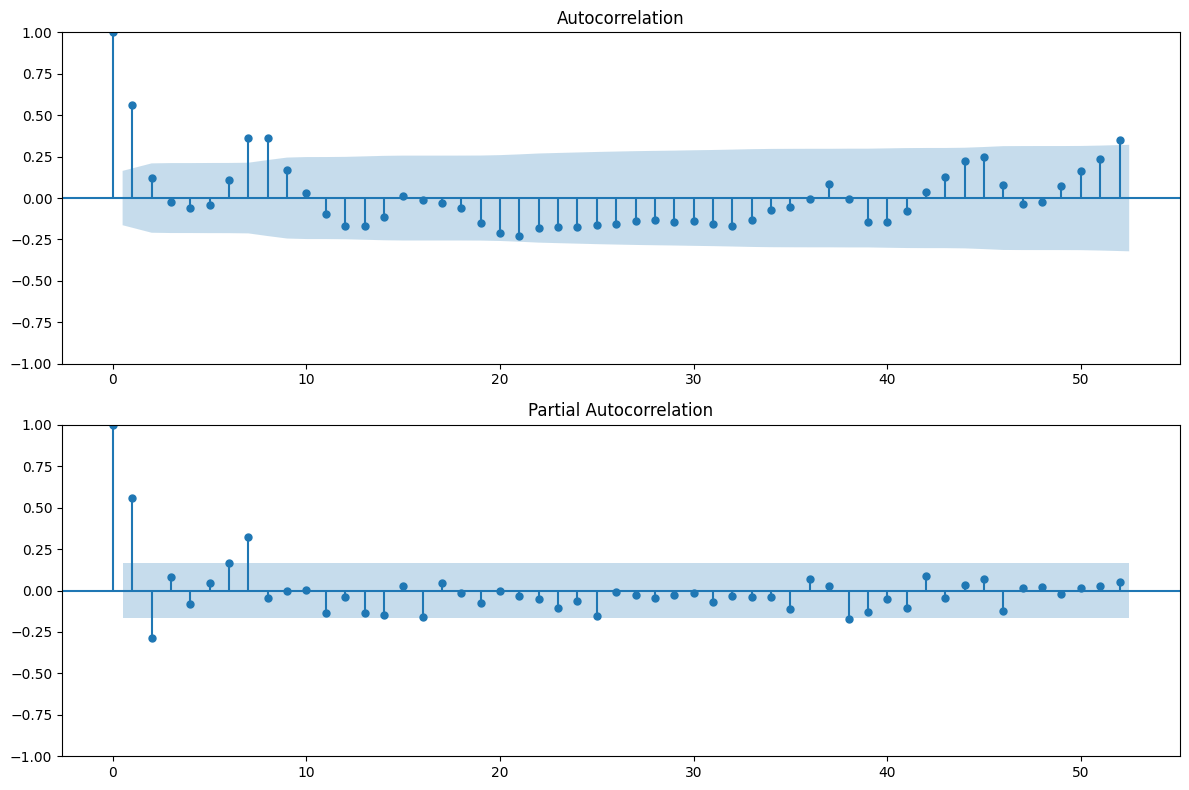

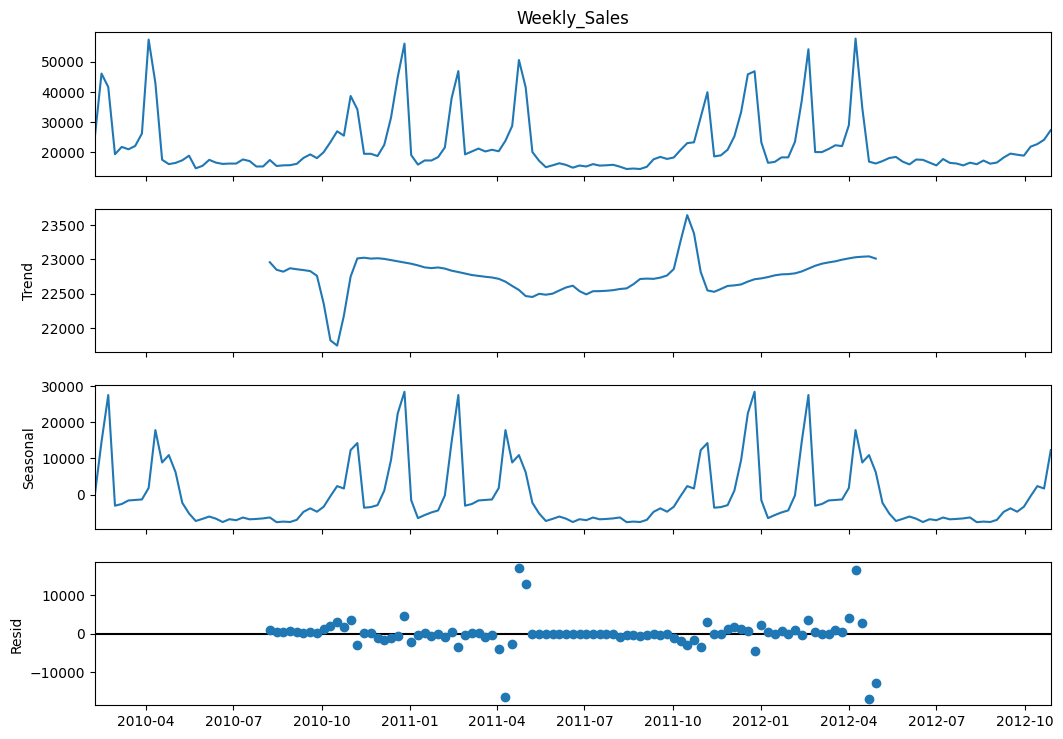

09:08:03 - cmdstanpy - INFO - Chain [1] start processing
09:08:04 - cmdstanpy - INFO - Chain [1] done processing



Model Comparison:
| Model   |     MAE |     RMSE |
|:--------|--------:|---------:|
| SARIMA  | 46174.8 | 47124.4  |
| ARIMA   | 18078.2 | 18650    |
| Prophet |  2169.3 |  3969.71 |


In [11]:
# Load and prepare data
data = load_data()
if data is not None:
    weekly_sales = prepare_time_series(data)
    
    # EDA
    plot_time_series(weekly_sales)
    seasonal_period = detect_seasonality(weekly_sales)
    
    # Model training and evaluation
    model_results = evaluate_models(weekly_sales)
else:
    print("Failed to load data")